# Observation to Model Comparison: CTDs

This notebook extracts CDT data in the xls format and extracts model data for those locations and plots
comparisons

Note: for now we have April through July 2024 data 

In [1]:
import subprocess
import os
import pandas as pd
import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy

import xarray as xr
from datetime import datetime, timedelta 
import dask
from scipy.interpolate import griddata
#from ocean_c_lab_tools import *
#from celluloid import Camera 
#import PyCO2SYS as csys
#import seawater as sw
from roms_regrid import *

### Extract observation data and read into xarray

In [4]:
xls = pd.ExcelFile('/home/x-uheede/R/HAFRO/Hafro_cruises.xls')

# combined dataset
combo = pd.read_excel(xls, 'combo',decimal='.')

obs=xr.Dataset.from_dataframe(combo)

# reformat into xarray dataset
obs=obs.set_index(index=['HV','Depth','mon/day/yr'])
obs=obs.drop_duplicates('index')
obs=obs.unstack('index')
obs=obs.rename(name_dict={'mon/day/yr':'time','Depth':'depth','Latitude(¬∞N)':'lat','Longitude(¬∞E)':'lon'})


### extract locations based on HV (which is station ID)

In [5]:

# define location which calculations the average location of each station
def get_location(obs, hv_values):
    locations = []
    for hv in hv_values:
        lat = obs['lat'].sel(HV=hv).isel(depth=0).mean('time').squeeze().values
        lon = obs['lon'].sel(HV=hv).isel(depth=0).mean('time').squeeze().values + 360
        locations.append([lat, lon])
    return locations

# List of HV values
hv_values = range(1, 13)

# Get the locations
locations = get_location(obs, hv_values)




### Load and regrid model-data

In [4]:

#x=xr.open_mfdataset('/pscratch/sd/u/uheede/from_expanse/Iceland3/*', combine='nested', concat_dim=["time"])
# open dataset
x=xr.open_mfdataset('/home/x-uheede/S/Iceland3_NOMARBL/Iceland3_MARBL_2024_rst.20240[3-4]??00????.nc', combine='nested', concat_dim=["time"])

# open grid
grid=xr.open_mfdataset('/home/x-uheede/S/Iceland3_MARBL_2024_60m/P_INPUT/Iceland3_grid_MAT.nc')
x=x.thin({'time': 24})
x_mean=x.sel(depth=[-0,-1,-2,-3,-4,-5,-7,-9,-10,-12,-14,-15,-16,-18,-20,-26,-30,-36,-40,-50,-80]).mean('time')
x_std=x.sel(depth=[-0,-1,-2,-3,-4,-5,-7,-9,-10,-12,-14,-15,-16,-18,-20,-26,-30,-36,-40,-50,-80]).std('time')
x=xr.concat([x_mean,x_std],dim="type")
t=x['t']
s=x['s']

# regridding
t=roms_regrid(grid,t)
s=roms_regrid(grid,s)
mask=roms_regrid(grid,grid['mask_rho'])
t=t.where(t != 0)
s=s.where(s != 0)
;

''

In [5]:
x

<xarray.Dataset> Size: 350MB
Dimensions:     (type: 2, depth: 21, eta_rho: 722, xi_rho: 722, xi_u: 721,
                 eta_v: 721)
Coordinates:
  * depth       (depth) float32 84B -0.0 -1.0 -2.0 -3.0 ... -40.0 -50.0 -80.0
Dimensions without coordinates: type, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    ocean_time  (type) float64 16B dask.array<chunksize=(1,), meta=np.ndarray>
    t           (type, depth, eta_rho, xi_rho) float32 88MB dask.array<chunksize=(1, 21, 722, 722), meta=np.ndarray>
    s           (type, depth, eta_rho, xi_rho) float32 88MB dask.array<chunksize=(1, 21, 722, 722), meta=np.ndarray>
    u           (type, depth, eta_rho, xi_u) float32 87MB dask.array<chunksize=(1, 21, 722, 721), meta=np.ndarray>
    v           (type, depth, eta_v, xi_rho) float32 87MB dask.array<chunksize=(1, 21, 721, 722), meta=np.ndarray>

In [6]:
t.load()
#t.to_netcdf('/global/cfs/cdirs/m4746/Users/ulla/run/Iceland3_MARBL/t_06.nc')
;

/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


''

/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


### plot a station overview

In [7]:
s.load()
#s.to_netcdf('/global/cfs/cdirs/m4746/Users/ulla/run/Iceland3_MARBL/s_06.nc')
;

''

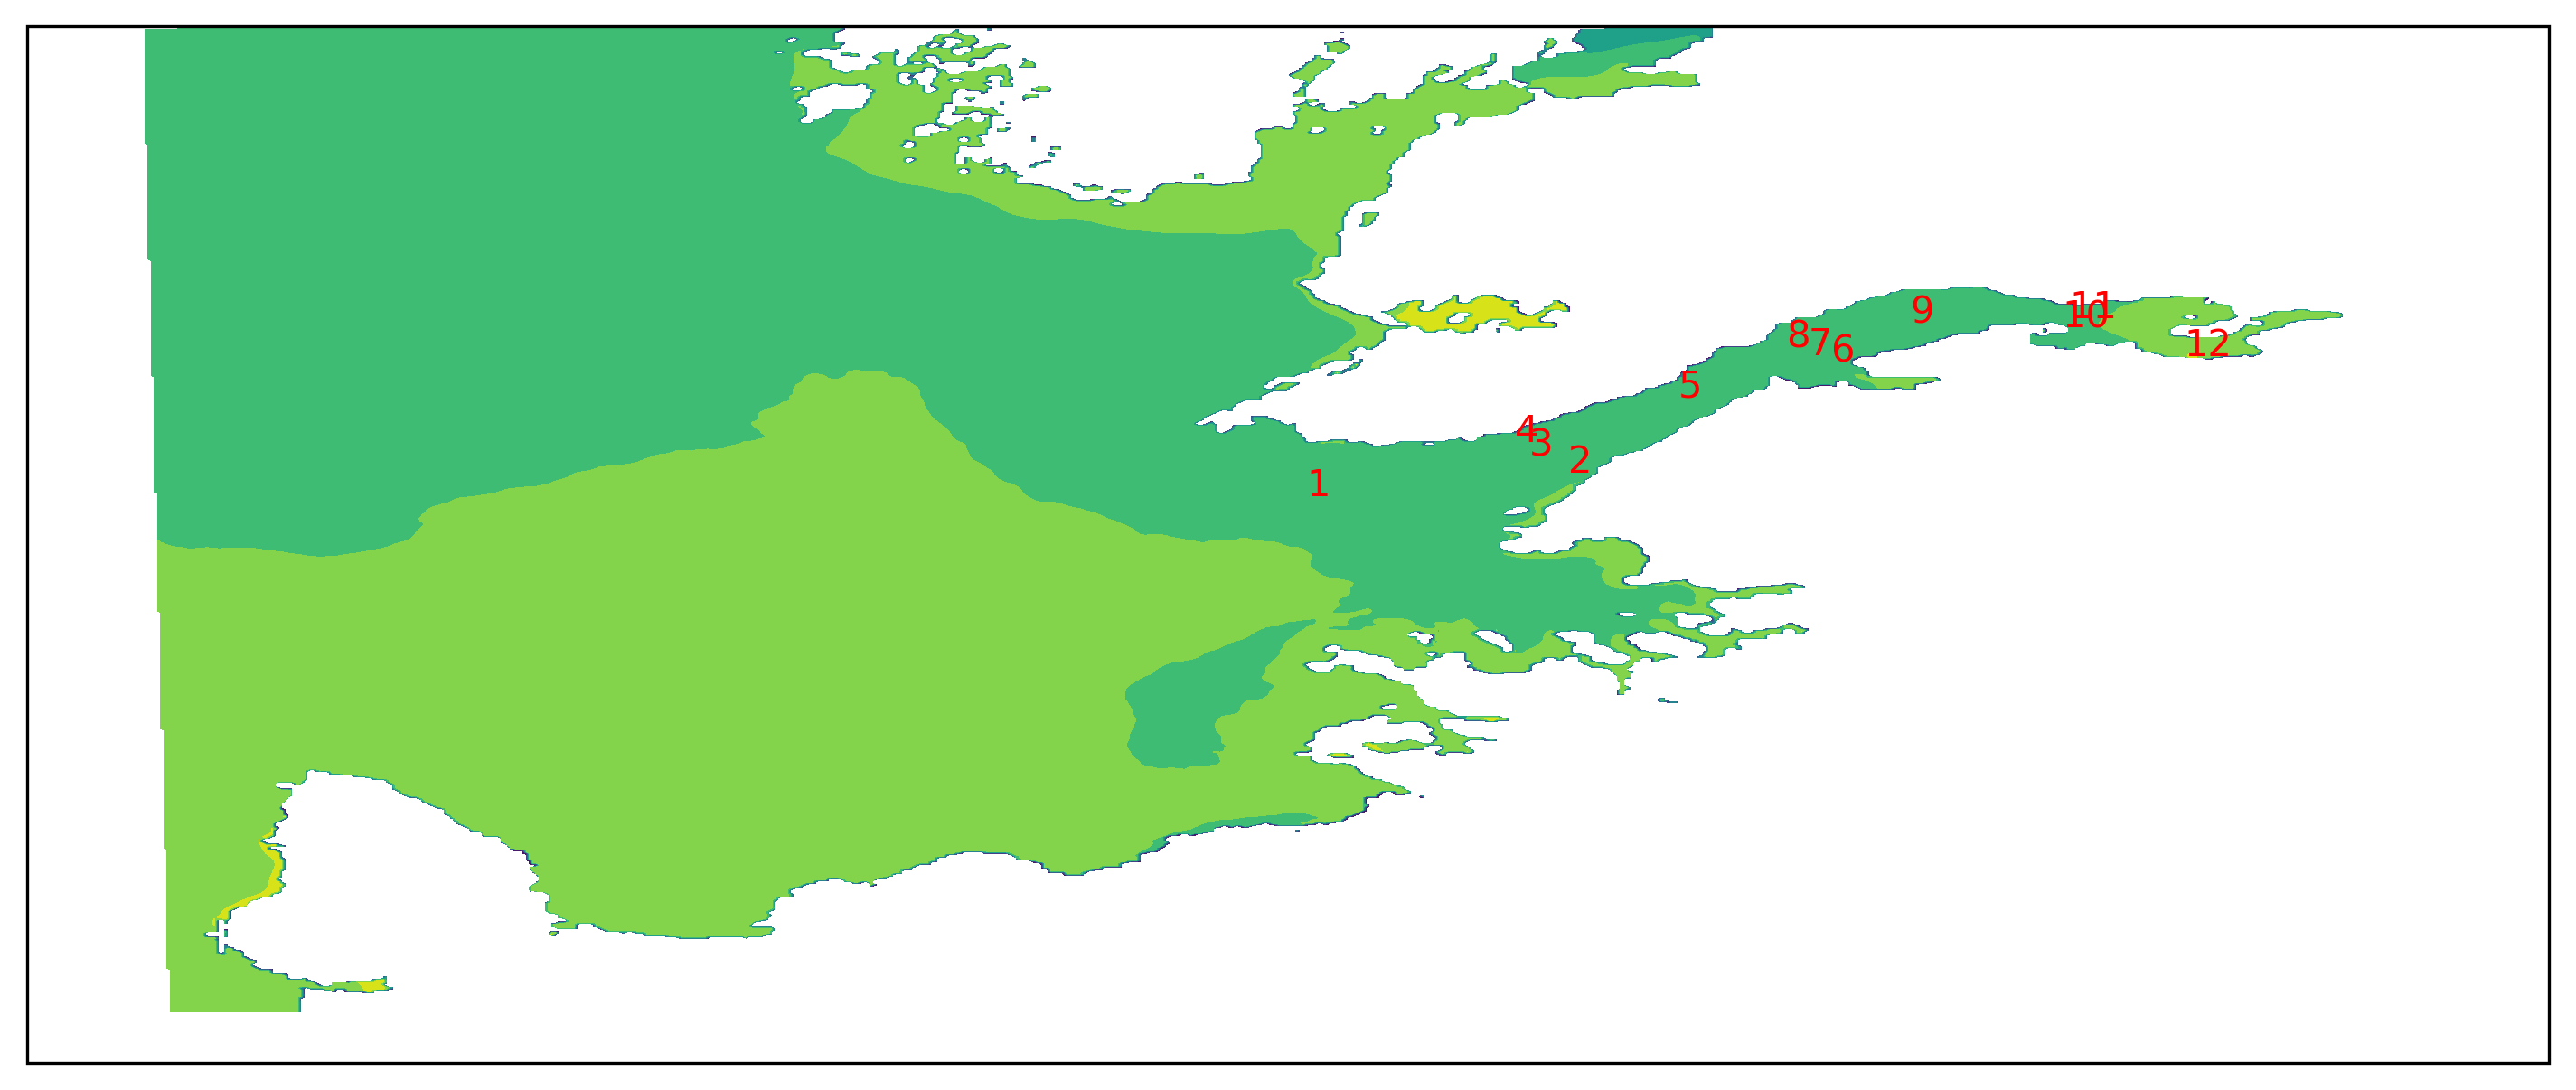

In [8]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the background t contour from ROMS
ax.contourf(t.lon, t.lat, t.isel(depth=0).isel(type=0), transform=ccrs.PlateCarree())

# Plot stations
for i, loc in enumerate(locations, start=1):
    ax.text(loc[1], loc[0], str(i), color='red', size=10, ha='center', va='center', transform=ccrs.PlateCarree())

plt.show()

### Plot mean profiles of each station (Temperature)

In [9]:

# Assuming locations is a list of lat/lon pairs
t_values = []
s_values = []
# Loop over the first 10 locations and store each selection in t_values
for i in range(12):
    lat, lon = locations[i]
    
    # Select the 't' values at the nearest lat/lon
    t_selected = t.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest')
    s_selected = s.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest')
    
    # Store the result in the list
    t_values.append(t_selected)
    s_values.append(s_selected)

# Combine the selections into an xarray Dataset or DataArray
t_values_combined = xr.concat(t_values, dim='location')
s_values_combined = xr.concat(s_values, dim='location')

# Assign a location coordinate for clarity (optional)
t_values_combined = t_values_combined.assign_coords(location=('location', range(1, 13)))
s_values_combined = s_values_combined.assign_coords(location=('location', range(1, 13)))
t_values_combined['depth']=t_values_combined.depth*(-1)
s_values_combined['depth']=s_values_combined.depth*(-1)
# Now you have t_values as an xarray object (Dataset or DataArray)
#print(t_values_combined)


/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_im

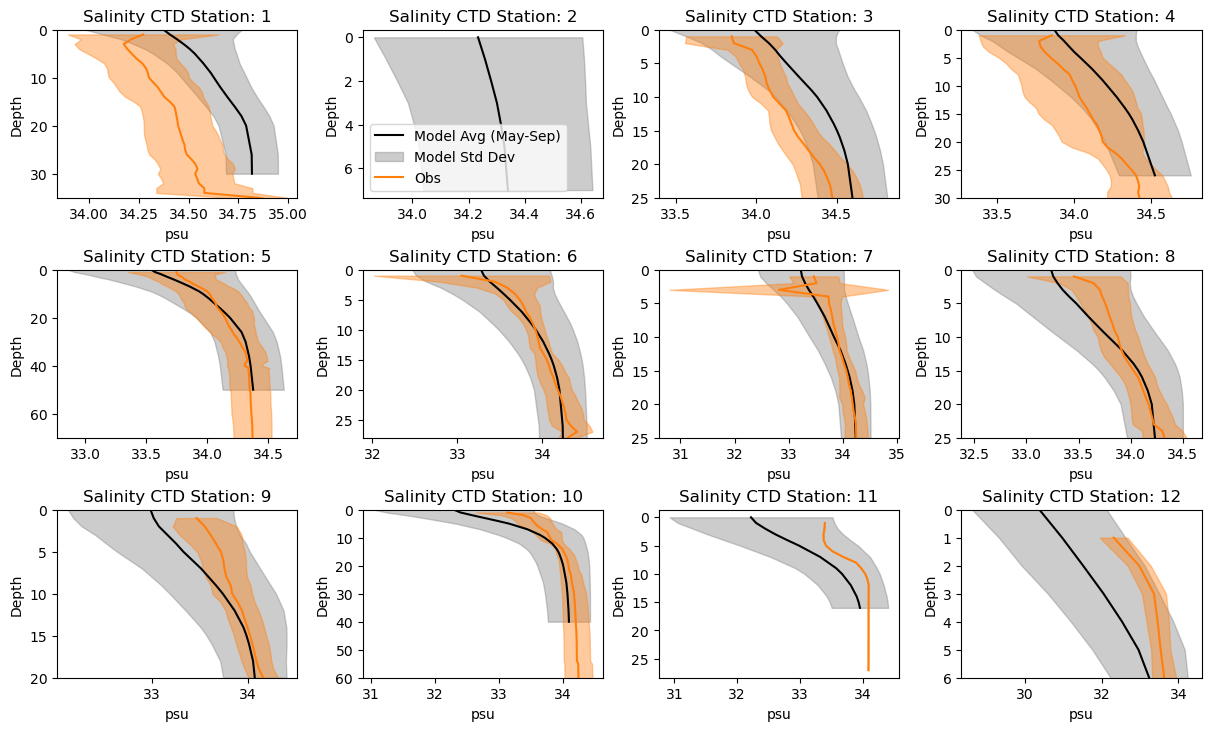

In [20]:
import matplotlib.pyplot as plt

# Set up the subplots
fig, axarr = plt.subplots(nrows=3, ncols=4, figsize=(12, 6*1.2), constrained_layout=True)
ax = axarr.flatten()  # Flatten to make indexing easier
palette = plt.get_cmap('tab20')

# Loop through 12 locations
for i in range(12):
    loc = i + 1  # location index starts at 1

    # Extract model data
    model_mean = s_values_combined.sel(type=0).sel(location=loc)
    model_std = s_values_combined.sel(type=1).sel(location=loc)

    # Plot model average
    ax[i].plot(model_mean, s_values_combined.depth, label='Model Avg (May-Sep)', color='black')

    # Plot shaded region for model standard deviation
    ax[i].fill_betweenx(s_values_combined.depth, model_mean - model_std, model_mean + model_std, 
                         color='grey', alpha=0.4, label='Model Std Dev')

    # Extract observed data
    ax[i].plot(obs['Salinity'].sel(HV=loc).dropna(dim='depth', how='all').sel(time=slice('05-01-2024', '09-15-2024')).mean('time'),
            obs.sel(HV=loc).dropna(dim='depth', how='all').depth, label='Obs', color=palette(2))

    obs_std = obs['Salinity'].sel(HV=loc).dropna(dim='depth', how='all').sel(time=slice('05-01-2024', '09-15-2024')).std('time')


    # Plot shaded region for observed standard deviation
    ax[i].fill_betweenx(obs.depth, (obs['Salinity'].sel(HV=loc).sel(time=slice('05-01-2024', '09-15-2024')).mean('time')-obs['Salinity'].sel(HV=loc).sel(time=slice('05-01-2024', '09-15-2024')).std('time')),(obs['Salinity'].sel(HV=loc).sel(time=slice('05-01-2024', '09-15-2024')).mean('time')+obs['Salinity'].sel(HV=loc).sel(time=slice('05-01-2024', '09-15-2024')).std('time')), color=palette(2), alpha=0.4)

    # Set depth limits for specific subplots
    ax[0].set_ylim(0,35)
    ax[2].set_ylim(0,25)
    ax[3].set_ylim(0,30)
    ax[4].set_ylim(0,70)
    ax[5].set_ylim(0,28)
    ax[6].set_ylim(0,25)
    ax[7].set_ylim(0,25)
    ax[8].set_ylim(0,20)
    ax[9].set_ylim(0,60)
    ax[11].set_ylim(0,6)

    # Set title, labels
    ax[i].set_title(f'Salinity CTD Station: {obs.HV[loc - 1].values}')
    ax[i].set_xlabel('psu')
    ax[i].set_ylabel('Depth')

    # Show legend only for the first subplot
    if i == 1:
        ax[i].legend()

for i in range(12):
    ax[i].invert_yaxis()
    
# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Set up the subplots
fig, axarr = plt.subplots(nrows=3, ncols=4, figsize=(12, 6*1.2), constrained_layout=True)
ax = axarr.flatten()  # Flatten to make indexing easier
palette = plt.get_cmap('tab20')

# Loop through 12 locations
for i in range(12):
    loc = i + 1  # location index starts at 1

    # Plot model average from mid-May 2012
    ax[i].plot(t_values_combined.sel(type=0).sel(location=loc), t_values_combined.depth,
               label='model average from mid-May 2023', color='black')
    
    # Plot model standard deviation
   # ax[i].plot(t_values_combined.sel(type=0).sel(location=loc) + t_values_combined.sel(type=1).sel(location=loc),
   #            t_values_combined.depth, label='model standard deviation', color='grey', alpha=0.4)
    
    #ax[i].plot(t_values_combined.sel(type=0).sel(location=loc) - t_values_combined.sel(type=1).sel(location=loc),
     #          t_values_combined.depth, color='grey', alpha=0.4)
    
    # Plot observed salinity for May 2024
    ax[i].plot(obs['Temperature'].sel(HV=loc).sel(time=slice('05-01-2024', '05-30-2024')).mean('time'),
               obs.depth, label='Obs', color=palette(2))
    
    ax[i].plot(obs['Temperature'].sel(HV=loc).sel(time=slice('05-01-2024', '05-30-2024')).mean('time')+obs['Temperature'].sel(HV=loc).sel(time=slice('05-01-2024', '05-30-2024')).std('time'),
               obs.depth, color=palette(2),alpha=0.4)
    
    ax[i].plot(obs['Temperature'].sel(HV=loc).sel(time=slice('05-01-2024', '05-30-2024')).mean('time')-obs['Temperature'].sel(HV=loc).sel(time=slice('05-01-2024', '05-30-2024')).std('time'),
               obs.depth, color=palette(2),alpha=0.4)
    
    # Invert y-axis
    ax[i].invert_yaxis()
    
    # Set title, labels, and legend for each subplot
    ax[i].set_title('Temperature CTD Station: ' + str(obs.HV[loc - 1].values))  # Title for each location
    ax[i].set_xlabel('psu')
    ax[i].set_ylabel('Depth')
    
    # Set limits (optional)
    #ax[i].set_xlim(32, 35)  # Example x-axis limits for psu
    
    # Only show the legend for the first subplot
    if i == 0:
        ax[i].legend()

# Display the plot
plt.show()


### create salinity contourplots

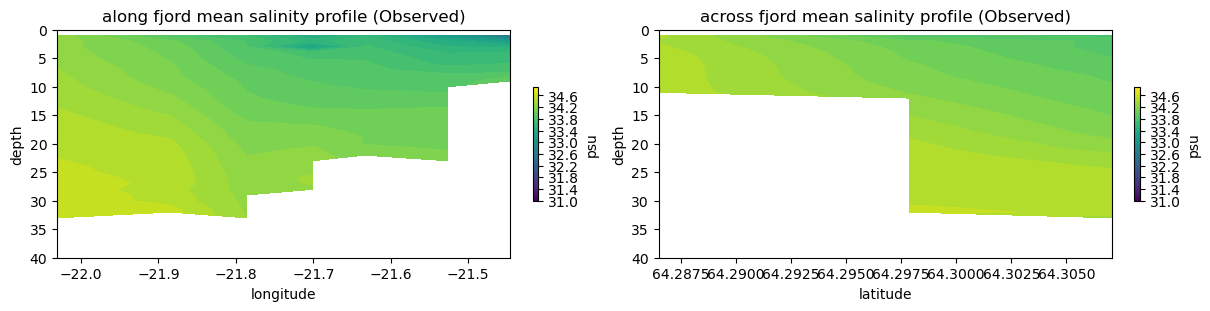

In [29]:
loc = np.array(locations)
levels_psu=np.arange(31,35,0.1)
levels_t=np.arange(2.5,10,0.2)
data_psu1=obs['Salinity'].sel(HV=[1,3,5,7,9,10,12]).mean('time')
data_psu2=obs['Salinity'].sel(HV=[2,3,4]).mean('time')
data_t=obs['Temperature'].sel(HV=[1,3,5,7,9,10,12]).mean('time')

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 3), constrained_layout=True)
ax = axarr.flatten()
c0=ax[0].contourf(loc[[1-1,3-1,5-1,7-1,9-1,10-1,12-1],1]-360,data_psu1.depth, data_psu1.transpose(),levels_psu)

#ax[1].contourf(loc[[1-1,3-1,5-1,7-1,9-1,10-1,12-1],1]-360,data.depth, data_t.transpose(),levels_t)
#ax[1].invert_yaxis()
c1=ax[1].contourf(loc[[2-1,3-1,4-1],0],data_psu2.depth, data_psu2.transpose(),levels_psu)

ax[0].set_title('along fjord mean salinity profile (Observed)')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth')
ax[0].set_ylim(0,40)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='psu',shrink=0.5)
ax[0].invert_yaxis()

ax[1].set_title('across fjord mean salinity profile (Observed)')
ax[1].set_xlabel('latitude')
ax[1].set_ylabel('depth')
ax[1].set_ylim(0,40)
plt.colorbar(c1, ax=ax[1], orientation='vertical', label='psu',shrink=0.5)
ax[1].invert_yaxis()

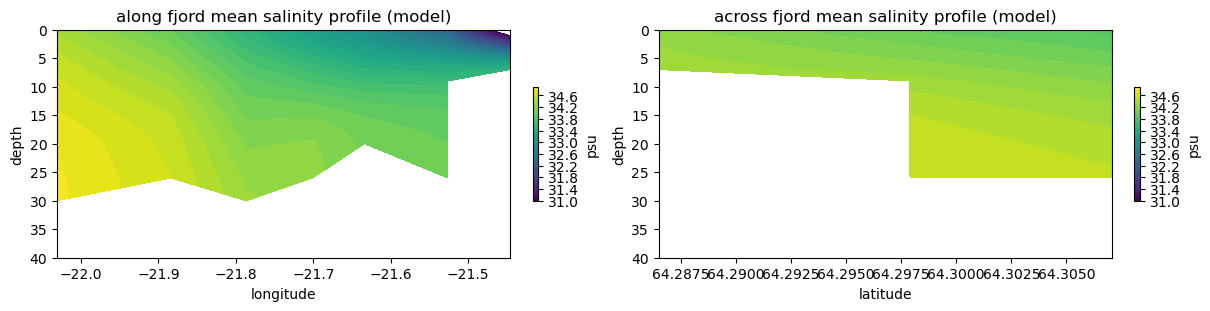

In [22]:
loc = np.array(locations)
levels_psu=np.arange(31,35,0.1)
levels_t=np.arange(2.5,10,0.2)
data_psu1=s_values_combined.sel(type=0).sel(location=[1,3,5,7,9,10,12])
data_psu2=s_values_combined.sel(type=0).sel(location=[2,3,4])


#data_t=obs['Temperature'].sel(HV=[1,3,5,7,9,10,12]).mean('time')

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 3), constrained_layout=True)
ax = axarr.flatten()
c0=ax[0].contourf(loc[[1-1,3-1,5-1,7-1,9-1,10-1,12-1],1]-360,data_psu1.depth, data_psu1.transpose(),levels_psu)

#ax[1].contourf(loc[[1-1,3-1,5-1,7-1,9-1,10-1,12-1],1]-360,data.depth, data_t.transpose(),levels_t)
#ax[1].invert_yaxis()
c1=ax[1].contourf(loc[[2-1,3-1,4-1],0],data_psu2.depth, data_psu2.transpose(),levels_psu)

ax[0].set_title('along fjord mean salinity profile (model)')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth')
ax[0].set_ylim(0,40)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='psu',shrink=0.5)
ax[0].invert_yaxis()

ax[1].set_title('across fjord mean salinity profile (model)')
ax[1].set_xlabel('latitude')
ax[1].set_ylabel('depth')
ax[1].set_ylim(0,40)
plt.colorbar(c1, ax=ax[1], orientation='vertical', label='psu',shrink=0.5)
ax[1].invert_yaxis()

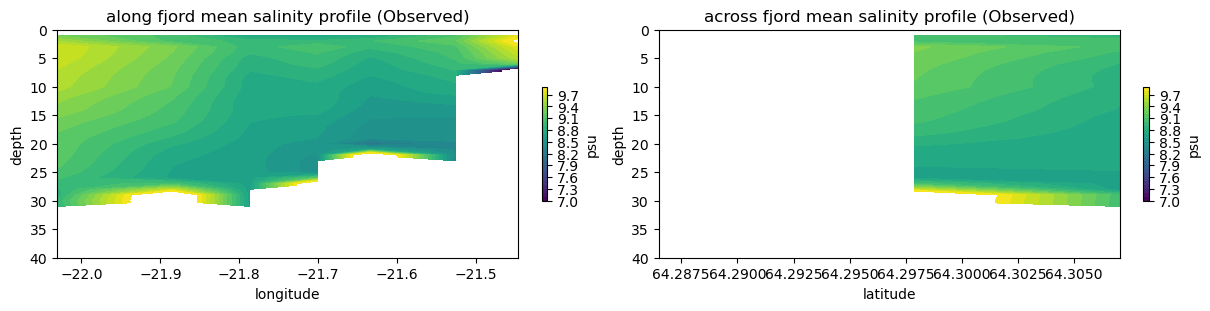

In [32]:
loc = np.array(locations)
levels_psu=np.arange(31,35,0.1)
levels_t=np.arange(7,10,0.1)
data_psu1=obs['Salinity'].sel(HV=[1,3,5,7,9,10,12]).mean('time')
data_psu2=obs['Salinity'].sel(HV=[2,3,4]).mean('time')
data_t1=obs['Temperature'].sel(HV=[1,3,5,7,9,10,12]).sel(time=slice('05-01-2024', '09-30-2024')).mean('time')
data_t2=obs['Temperature'].sel(HV=[2,3,4]).sel(time=slice('05-01-2024', '09-30-2024')).mean('time')

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 3), constrained_layout=True)
ax = axarr.flatten()
c0=ax[0].contourf(loc[[1-1,3-1,5-1,7-1,9-1,10-1,12-1],1]-360,data_t1.depth, data_t1.transpose(),levels_t)

#ax[1].contourf(loc[[1-1,3-1,5-1,7-1,9-1,10-1,12-1],1]-360,data.depth, data_t.transpose(),levels_t)
#ax[1].invert_yaxis()
c1=ax[1].contourf(loc[[2-1,3-1,4-1],0],data_t2.depth, data_t2.transpose(),levels_t)

ax[0].set_title('along fjord mean salinity profile (Observed)')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth')
ax[0].set_ylim(0,40)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='psu',shrink=0.5)
ax[0].invert_yaxis()

ax[1].set_title('across fjord mean salinity profile (Observed)')
ax[1].set_xlabel('latitude')
ax[1].set_ylabel('depth')
ax[1].set_ylim(0,40)
plt.colorbar(c1, ax=ax[1], orientation='vertical', label='psu',shrink=0.5)
ax[1].invert_yaxis()

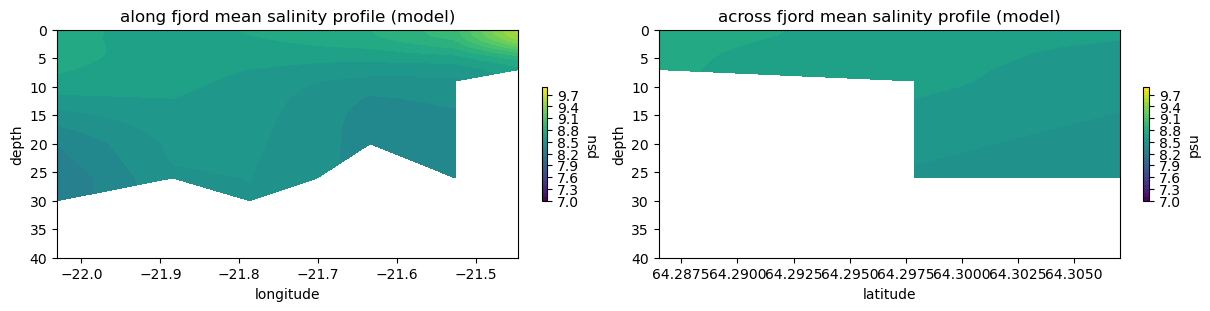

In [25]:
loc = np.array(locations)
levels_psu=np.arange(31,35,0.1)
levels_t=np.arange(7,10,0.1)
data_psu1=s_values_combined.sel(type=0).sel(location=[1,3,5,7,9,10,12])
data_psu2=s_values_combined.sel(type=0).sel(location=[2,3,4])

data_t1=t_values_combined.sel(type=0).sel(location=[1,3,5,7,9,10,12])
data_t2=t_values_combined.sel(type=0).sel(location=[2,3,4])


fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 3), constrained_layout=True)
ax = axarr.flatten()
c0=ax[0].contourf(loc[[1-1,3-1,5-1,7-1,9-1,10-1,12-1],1]-360,data_t1.depth, data_t1.transpose(),levels_t)


c1=ax[1].contourf(loc[[2-1,3-1,4-1],0],data_t2.depth, data_t2.transpose(),levels_t)

ax[0].set_title('along fjord mean temperature profile (model)')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth')
ax[0].set_ylim(0,40)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='psu',shrink=0.5)
ax[0].invert_yaxis()

ax[1].set_title('across fjord mean temperature profile (model)')
ax[1].set_xlabel('latitude')
ax[1].set_ylabel('depth')
ax[1].set_ylim(0,40)
plt.colorbar(c1, ax=ax[1], orientation='vertical', label='psu',shrink=0.5)
ax[1].invert_yaxis()

In [33]:

#x=xr.open_mfdataset('/pscratch/sd/u/uheede/from_expanse/Iceland3/*', combine='nested', concat_dim=["time"])
# open dataset
x=xr.open_mfdataset('/pscratch/sd/u/uheede/Iceland3_riv/z_Iceland3_MARBL_rnd.20230[5-9]????????.nc', combine='nested', concat_dim=["time"])
x=x.thin({'time': 24})

ocean_time=x['ocean_time']
reference_date = np.datetime64('2000-01-01T00:00:00')

# Convert seconds to datetime
datetime_array = reference_date + ocean_time.astype('timedelta64[s]')

# open grid
grid=xr.open_mfdataset('/global/cfs/cdirs/m4632/uheede/work/Iceland3_MARBL/INPUT/Iceland3_grd.nc')

x_mean=x.sel(depth=[-2,-3,-4,-5]).mean('depth')
x_std=x.sel(depth=[-2,-3,-4,-5]).mean('depth')
x=xr.concat([x_mean,x_std],dim="type")
t=x['t']
s=x['s']

# regridding
t=roms_regrid(grid,t)
s=roms_regrid(grid,s)
mask=roms_regrid(grid,grid['mask_rho'])
t=t.where(t != 0)
s=s.where(s != 0)
;

''

In [34]:

t.load()
s.load()
;

''

In [35]:

# Assuming locations is a list of lat/lon pairs
t_values = []
s_values = []
# Loop over the first 10 locations and store each selection in t_values
for i in range(12):
    lat, lon = locations[i]
    
    # Select the 't' values at the nearest lat/lon
    t_selected = t.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest')
    s_selected = s.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest')
    
    # Store the result in the list
    t_values.append(t_selected)
    s_values.append(s_selected)

# Combine the selections into an xarray Dataset or DataArray
t_values_combined = xr.concat(t_values, dim='location')
s_values_combined = xr.concat(s_values, dim='location')

# Assign a location coordinate for clarity (optional)
t_values_combined = t_values_combined.assign_coords(location=('location', range(1, 13)))
s_values_combined = s_values_combined.assign_coords(location=('location', range(1, 13)))
#t_values_combined['depth']=t_values_combined.depth*(-1)
#s_values_combined['depth']=s_values_combined.depth*(-1)
# Now you have t_values as an xarray object (Dataset or DataArray)
#print(t_values_combined)


# Compare with model (to be corrected when new model run is done)

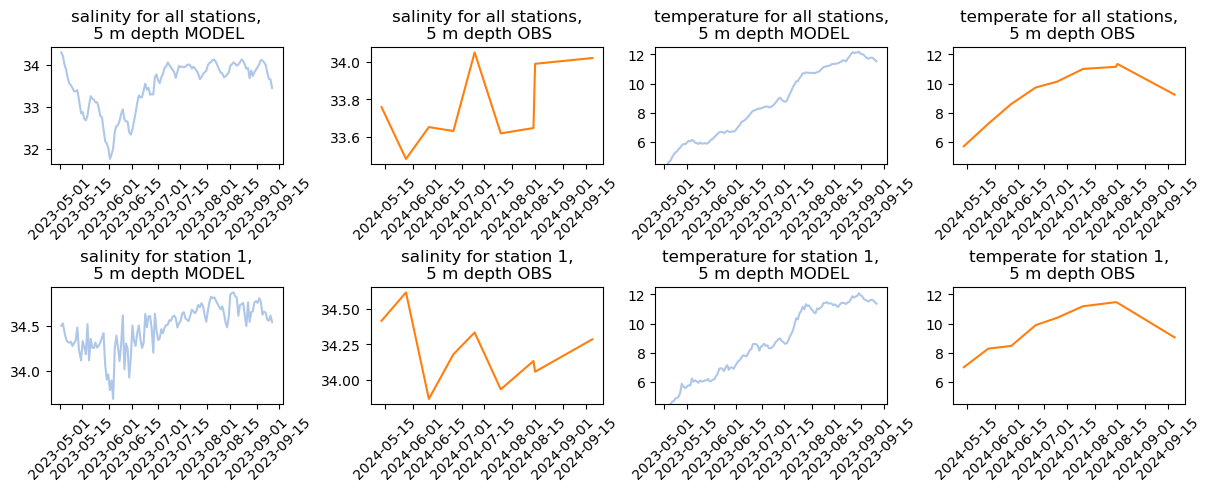

In [40]:
import matplotlib.pyplot as plt

# Set up the subplots
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(12, 4*1.2), constrained_layout=True)
ax = axarr.flatten()  # Flatten to make indexing easier
palette = plt.get_cmap('tab20')

# Plot observed salinity for May 2024
ax[1].plot(obs.time.sel(time=slice('05-01-2024', '09-30-2024')),
           obs['Salinity'].sel(depth=slice(2,5)).mean('depth').sel(HV=[1,3,4,5,6,7,8,9,10,12]).sel(time=slice('05-01-2024', '09-30-2024')).mean('HV'),
           label='May', color=palette(2))

ax[0].plot(datetime_array, s_values_combined.sel(type=0).sel(location=[1,3,4,5,6,7,8,9,10,12]).mean('location'),
           label='May', color=palette(1))

# Plot observed salinity for May 2024
ax[3].plot(obs.time.sel(time=slice('05-01-2024', '09-30-2024')),
           obs['Temperature'].sel(depth=slice(2,5)).mean('depth').sel(HV=[1,3,4,5,6,7,8,9,10,12]).sel(time=slice('05-01-2024', '09-30-2024')).mean('HV'),
           label='May', color=palette(2))
ax[3].set_ylim(4.5,12.5)

ax[2].plot(datetime_array, t_values_combined.sel(type=0).sel(location=[1,3,4,5,6,7,8,9,10,12]).mean('location'),
           label='May', color=palette(1))
ax[2].set_ylim(4.5,12.5)
ax[5].plot(obs.time.sel(time=slice('05-01-2024', '09-30-2024')),
           obs['Salinity'].sel(depth=slice(2,5)).mean('depth').sel(HV=[1]).sel(time=slice('05-01-2024', '09-30-2024')).mean('HV'),
           label='May', color=palette(2))

ax[4].plot(datetime_array, s_values_combined.sel(type=0).sel(location=[1]).mean('location'),
           label='May', color=palette(1))

# Plot observed salinity for May 2024
ax[7].plot(obs.time.sel(time=slice('05-01-2024', '09-30-2024')),
           obs['Temperature'].sel(depth=slice(2,5)).mean('depth').sel(HV=[1]).sel(time=slice('05-01-2024', '09-30-2024')).mean('HV'),
           label='May', color=palette(2))
ax[7].set_ylim(4.5,12.5)
ax[6].plot(datetime_array, t_values_combined.sel(type=0).sel(location=[1]).mean('location'),
           label='May', color=palette(1))
ax[6].set_ylim(4.5,12.5)
# Rotate x-axis labels for all subplots
for a in ax:
    a.tick_params(axis='x', rotation=45)  # Adjust rotation angle as needed
    
    
ax[0].set_title('salinity for all stations,\n 5 m depth MODEL')
ax[1].set_title('salinity for all stations,\n 5 m depth OBS')
ax[2].set_title('temperature for all stations,\n 5 m depth MODEL')
ax[3].set_title('temperate for all stations,\n 5 m depth OBS')
ax[4].set_title('salinity for station 1,\n 5 m depth MODEL')
ax[5].set_title('salinity for station 1,\n 5 m depth OBS')
ax[6].set_title('temperature for station 1,\n 5 m depth MODEL')
ax[7].set_title('temperate for station 1,\n 5 m depth OBS')
plt.show()



In [ ]:
ocean_time.load()

In [ ]:
x['ocean_time'].load()

In [ ]:
plt.plot(t_values_combined.sel(type=0).sel(location=3))

In [ ]:
x

In [ ]:
obs